# Detection of Spatial Signatures in Dar es Salaam

This notebook contains complete code required for a detection of spatial signatures in Dar es Salaam, limited by its functional urban area.

This notebook relies on the `gds_env` as its main computational engine, which is deployed on a variety of servers and setups. This means that all the code produced in the project is reproducible under the containers provided in `gds_env`. This notebook uses `gds_py` flavour in a version `6.0`.

For more information on how to run `gds_env`, please visit:

> https://darribas.org/gds_env/

## Contents

- 1. Analysis of form
    - 1.1. Data retrieval
        - 1.1.1. Bulding footprints
        - 1.1.2. Street network
        - 1.1.3. Spatial barriers
    - 1.2. Data pre-processing
        - 1.2.1. Footprints checks and cleaning
        - 1.2.2. Barries checks and cleaning
    - 1.3. Generation of geographies
        - 1.3.1. Enclosures
        - 1.3.2. Enlclosed tessellation
    - 1.4. Morphometric analysis
        - 1.4.1. Primary morphometric characters
        - 1.4.2. Contextualisation
- 2. Analysis of function
    - 2.1. Number of dwellings, Building use, Age
    - 2.2. Land Use
    - 2.3. Block-level data
    - 2.4. Heritage
    - 2.5. Restaurants
    - 2.6. Economic census POIs
    - 2.7. Culture
    - 2.8. Parks
    - 2.9. Trees
    - 2.10. NDVI
- 3. Cluster analysis
    - 3.1. Form
    - 3.2. Function
    - 3.3. Spatial Signatures
- 4. Figures

All packages and custom modules are imported below.

In [1]:
import glob
import os
import pickle
import subprocess
import warnings

import dask_geopandas
import geopandas
import geopandas as gpd
import libpysal
import momepy
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import pygeos
import pyrosm
import rasterstats
import rioxarray
import scipy
import utils
import utils.momepy
import xarray
from clustergram import Clustergram
from dask import dataframe as dd
from dask.distributed import Client, LocalCluster
from dask.system import cpu_count
from download import download
from numpy import percentile
from shapely.geometry import box, mapping
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm import tqdm
from utils.momepy_utils import (_circle_radius, centroid_corner, elongation,
                                get_corners, get_edge_ratios, get_nodes,
                                solar_orientation_poly, squareness)


Most of our data will be stored as geospatial parquet files, which is currently (Feb 2021) in its intial implementation, but we know that and can filter warnings.

In [2]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

First we specify a path to a folder for a data storage.

In [4]:
folder = "../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/"

Case study area is limited by functional urban area (FUA), so let's open all FUAs and filter our polygon.

In [ ]:
fua = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")

We have to reproject data and clean topology.

In [51]:
fua_4326 = fua.to_crs(4326)
fua_4326.geometry = fua_4326.buffer(0)  # fix geometry topology

In [5]:
des_fua = polygon = fua_4326[fua_4326.eFUA_name == 'Dar es Salaam'].geometry.iloc[0]

## 1. Analysis of form

First step towards spatial signtures is an analysis of urban form to capture its patterns.

### 1.1. Data retrieval

All data used in the work are obtained from open access sources.

#### 1.1.1 Building footprints

Building footprints are obtained from OSM using pyrosm. We first download pbf archive for Tanzania.

In [8]:
%time fp = pyrosm.get_data("tanzania", directory="../../urbangrammar_samba/sp_sig_concept/dar_es_salaam")

Downloaded Protobuf data 'tanzania-latest.osm.pbf' (464.53 MB) to:
'/home/jovyan/work/urbangrammar_samba/sp_sig_concept/dar_es_salaam/tanzania-latest.osm.pbf'
CPU times: user 1.42 s, sys: 1.77 s, total: 3.19 s
Wall time: 16.6 s


In [6]:
fp = '/home/jovyan/work/urbangrammar_samba/sp_sig_concept/dar_es_salaam/tanzania-latest.osm.pbf'

Then we load pbf to pyrosm.

In [7]:
%time osm = pyrosm.OSM(fp)

CPU times: user 1.74 ms, sys: 658 µs, total: 2.4 ms
Wall time: 10.1 ms


And extract all buildings.

In [15]:
%time buildings = osm.get_buildings()

CPU times: user 8min 48s, sys: 37.1 s, total: 9min 25s
Wall time: 9min 21s


Finally, we filter those within our FUA.

In [16]:
%time dar = buildings.iloc[buildings.sindex.query(des_fua, predicate='intersects')]

CPU times: user 13.3 s, sys: 594 ms, total: 13.9 s
Wall time: 13.9 s


Then we reproject it and save to a file.

In [ ]:
dar = dar.to_crs(gdf.crs)

In [19]:
dar[['building', 'building:levels', 'geometry']].to_parquet(folder + 'footprints_osm.pq')

#### 1.1.2 Street network

Street network is obtined from OSM using OSMnx, and custom tags.

We get a graph, project it, turn into undirected one and export to GeoDataFrame. Then we make sure `highway` parameter is string and can be saved to file.

In [7]:
%%time
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

streets_graph = ox.graph_from_polygon(polygon, network_type='all_private', custom_filter=type_filter, retain_all=True)
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.highway = gdf.highway.astype(str)
path = folder + 'roads_osm.pq'
gdf[['highway', 'geometry']].to_parquet(path)

CPU times: user 2min 25s, sys: 1.27 s, total: 2min 26s
Wall time: 2min 42s


#### 1.1.3. Spatial barriers

Identification of enclosures should optimally contain variety of barriers, not only street networks. Therefore, we download railway and water geometry from OSM.

##### Water

In [ ]:
%%time
tags = {'natural': ['water', 'coastline', 'spring']}
gdf = ox.geometries_from_polygon(des_fua, tags)
path = folder + 'water_osm.pq'
gdf[['natural', 'geometry']].to_parquet(path)

##### Railway

Then we get railway and filter out proper geometry type (we want LineStrings representing railway tracks).

In [ ]:
%%time
tags = {'railway': True}
gdf = ox.geometries_from_polygon(des_fua, tags)
path = folder + 'railway_osm.pq'
gdf[['railway', 'geometry']].to_parquet(path)

### 1.2. Data pre-processing

Before we can analyse form using the data we just downloaded, we need to ensure that they are in a proper form.

#### 1.2.1. Footprints checks and cleaning

Let's start with building footprints.

In [4]:
buildings = gpd.read_parquet(folder + 'footprints_osm.pq')

OSM data tend to be messy, so we need to check validity and geometry types.

In [5]:
buildings.geom_type.value_counts()

Polygon            1161335
MultiLineString         96
MultiPolygon            20
LineString               9
dtype: int64

We explode geometries and keep only polygons.

In [9]:
buildings = buildings.reset_index(drop=True).explode().reset_index(drop=True)
buildings = buildings[buildings.geom_type == 'Polygon']

We can then use `momepy.CheckTessellationInput()` class to check for potential issues which may arise during enclosed tessellation.

In [10]:
%time check = momepy.CheckTessellationInput(buildings)

Collapsed features  : 572
Split features      : 419
Overlapping features: 154
CPU times: user 1min 27s, sys: 2.1 s, total: 1min 29s
Wall time: 1min 27s


In the ideal case, we should fix overlapping geometry. For the sake of examples, that is not necessary and we may drop them as well as buildings which would collapse.

In [11]:
buildings = buildings.drop(check.collapse.index.union(check.overlap.index))

In [12]:
buildings.shape

(1160654, 3)

We have to clean topology.

In [60]:
buildings.is_valid.all()

False

In [61]:
buildings.geometry = buildings.buffer(0)

In [62]:
buildings.is_valid.all()

True

This results in 1 160 654 cleaned buildings. We will assign unique ID to each of them and save them to a file.

In [13]:
buildings["uID"] = range(len(buildings))
%time buildings.to_parquet(folder + "buildings.pq")

CPU times: user 2.04 s, sys: 243 ms, total: 2.28 s
Wall time: 3.36 s


#### 1.2.2. Barries checks and cleaning

Let's now check our barriers and close potential unwanted gaps to generate clean enclosures

In [41]:
roads = gpd.read_parquet(folder + "roads_osm.pq").to_crs(buildings.crs)

In [42]:
roads.geom_type.unique()

array(['LineString'], dtype=object)

In [43]:
railway = gpd.read_parquet(folder + 'railway_osm.pq').to_crs(buildings.crs)

In [44]:
railway.geom_type.unique()

array(['Point', 'LineString', 'Polygon'], dtype=object)

In [45]:
railway = railway[railway.geom_type == 'LineString']

Roads seems to be fine, railway required geometry type filtering. The only other step we do is extension of railway lines to snap to roads.

In [46]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

In [47]:
water = gpd.read_parquet(folder + "water_osm.pq").to_crs(buildings.crs)

In [48]:
coastline = water[water.geom_type =='LineString']

### 1.3. Generation of geographies

Now we have to create geographies we will be using in the analysis. Enclosures and enclosed tessellation.

#### 1.3.1. Enclosures

Enclosures require spatial barriers, which are roads, water and railway (we use the extended one we did above), limited by FUA.

In [55]:
des_fua = fua_4326.to_crs(buildings.crs)[fua_4326.eFUA_name == 'Dar es Salaam']

In [56]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=des_fua, additional_barriers=[extended_railway, coastline])

CPU times: user 9.17 s, sys: 2.16 ms, total: 9.17 s
Wall time: 9.17 s


In [63]:
enclosures.is_valid.all()

True

#### 1.3.2. Enclosed tessellation

With enclosures and buildings, we can now create enclosed tessellation.

In [64]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures)

CPU times: user 8h 10min 33s, sys: 39min 38s, total: 8h 50min 11s
Wall time: 3h 14min 31s


Finally, we can save both newly generated geographies to files.

In [65]:
tess.tessellation.to_parquet(folder + "tessellation.pq")

In [66]:
enclosures.to_parquet(folder + "enclosures.pq")

### 1.4. Morphometric analysis

Morpohmetric analysis first measures primary characters, which are then contextualised to capture the tendencies within the local context of each tessellation cell.

#### 1.4.1. Primary morphometric characters

For the analysis we need four input layer representing urban form - buildings, streets, enclosed tessellation and enclosures.

In [36]:
# !pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-yno_dbwm
  Created wheel for geopandas: filename=geopandas-0.8.0+73.g1ef9242-py2.py3-none-any.whl size=973544 sha256=4725e193f05b223d15eab14ae701f25ce031fa786914e31f217511b95b55382e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mozpnn91/wheels/37/ce/df/09721a3e578b57e217d038d0555fd872eba4e1fd9c8f6c8013
Successfully built geopandas
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.8.1
    Uninstalling geopandas-0.8.1:
      Successfully uninstalled geopandas-0.8.1


In [3]:
tess = gpd.read_parquet(folder + "tessellation.pq")
enclosures = gpd.read_parquet(folder + "enclosures.pq")
buildings = gpd.read_parquet(folder + "buildings.pq")

In [4]:
tess = tess.rename_geometry("tessellation").merge(buildings[['uID', 'geometry']].rename_geometry("buildings"), on='uID', how='left')

In [5]:
tess['tID'] = range(len(tess))
tess.head(5)

uID                                       tessellation  eID  \
0  784070.0  POLYGON ((530753.667 -751662.183, 530753.915 -...    0   
1  785052.0  POLYGON ((530753.915 -751662.504, 530753.667 -...    0   
2  785854.0  POLYGON ((530710.355 -751642.103, 530709.850 -...    0   
3  786074.0  POLYGON ((530709.663 -751625.639, 530708.164 -...    0   
4  786327.0  POLYGON ((530744.095 -751637.861, 530744.095 -...    0   

                                           buildings  tID  
0  POLYGON ((530671.226 -751656.231, 530671.497 -...    0  
1  POLYGON ((530746.821 -751631.899, 530756.257 -...    1  
2  POLYGON ((530680.755 -751609.597, 530694.811 -...    2  
3  POLYGON ((530696.687 -751613.442, 530705.825 -...    3  
4  POLYGON ((530727.804 -751594.126, 530743.086 -...    4

In [6]:
tess.shape

(1168896, 5)

In [7]:
tess.tessellation.geom_type.value_counts()

Polygon         1159492
MultiPolygon       9404
dtype: int64

In [8]:
client = Client(LocalCluster(n_workers=16))
client

<Client: 'tcp://127.0.0.1:44957' processes=16 threads=16, memory=134.91 GB>

In [9]:
warnings.filterwarnings('ignore', message='.*Assigning CRS to a GeoDataFrame without a geometry*')

In [10]:
ddf = dask_geopandas.from_geopandas(tess, npartitions=16)

In [11]:
%%time
## Measure morphometric characters
# Building area
ddf['sdbAre'] = ddf.buildings.area

# Building perimeter
ddf['sdbPer'] = ddf.buildings.length

# Courtyard area
exterior_area = ddf.buildings.map_partitions(lambda series: pygeos.area(pygeos.polygons(series.exterior.values.data)), meta='float')
ddf['sdbCoA'] = exterior_area - ddf['sdbAre']

# Circular compactness
hull = ddf.buildings.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
ddf['ssbCCo'] = ddf['sdbAre'] / (np.pi * radius ** 2)

# Corners
ddf['ssbCor'] = ddf.buildings.apply(lambda g: get_corners(g), meta='float')

# Squareness
ddf['ssbSqu'] = ddf.buildings.apply(lambda g: squareness(g), meta='float')

# Equivalent rectangular index
bbox = ddf.buildings.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=geopandas.GeoSeries())
ddf['ssbERI'] = (ddf['sdbAre'] / bbox.area).pow(1./2) * (bbox.length / ddf['sdbPer'])

# Elongation
ddf['ssbElo'] = bbox.map_partitions(lambda s: elongation(s), meta='float')

# Centroid corner mean distance and deviation
def _centroid_corner(series):
    ccd = series.apply(lambda g: centroid_corner(g))
    return pd.DataFrame(ccd.to_list(), index=series.index)


ddf[['ssbCCM', 'ssbCCD']] = ddf.buildings.map_partitions(_centroid_corner, meta=pd.DataFrame({0: [0.1], 1: [1.1]}))

# Solar orientation
ddf['stbOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Tessellation longest axis length
hull = ddf.tessellation.convex_hull.exterior

ddf['sdcLAL'] = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2

# Tessellation area
ddf['sdcAre'] = ddf.tessellation.area

# Circular compactness
radius = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float')
ddf['sscCCo'] = ddf['sdcAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = ddf.tessellation.apply(lambda g: g.minimum_rotated_rectangle, meta=geopandas.GeoSeries())
ddf['sscERI'] = (ddf['sdcAre'] / bbox.area).pow(1./2) * (bbox.length / ddf.tessellation.length)

# Solar orientation
ddf['stcOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Covered area ratio
ddf['sicCAR'] = ddf['sdbAre'] / ddf['sdcAre']

# Building-cell alignment
ddf['stbCeA'] = (ddf['stbOri'] - ddf['stcOri']).abs()

# Compute all characters using dask
df = ddf.compute()

CPU times: user 46.5 s, sys: 10.8 s, total: 57.2 s
Wall time: 7min 2s


In [13]:
df.to_parquet(folder + "tess.pq")

In [20]:
%%time
# Load data
encl = dask_geopandas.from_geopandas(enclosures, npartitions=16)

# Area
encl['ldeAre'] = encl.geometry.area

# Perimeter
encl['ldePer'] = encl.geometry.length

# Circular compacntess
hull = encl.geometry.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
encl['lseCCo'] = encl['ldeAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = encl.geometry.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=geopandas.GeoSeries())
encl['lseERI'] = (encl['ldeAre'] / bbox.area).pow(1./2) * (bbox.length / encl['ldePer'])

# Compactness-weighted axis
longest_axis = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2
encl['lseCWA'] = longest_axis * ((4 / np.pi) - (16 * encl['ldeAre']) / ((encl['ldePer']) ** 2))

# Solar orientation
encl['lteOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Compute data and return geopandas.GeoDataFrame
encl_df = encl.compute()

# Weighted number of neighbors
inp, res = encl_df.sindex.query_bulk(encl_df.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
encl_df['neighbors'] = counts - 1
encl_df['lteWNB'] = encl_df['neighbors'] / encl_df['ldePer']

# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = encl_df[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
encl_df['lieWCe'] = merged['tessellation'] / merged['ldeAre']

CPU times: user 17.1 s, sys: 8.49 ms, total: 17.1 s
Wall time: 17 s


In [21]:
encl_df

eID                                           geometry        ldeAre  \
0          0  POLYGON ((530775.476 -751454.057, 530850.409 -...  5.367294e+04   
1          1  POLYGON ((530850.409 -751543.997, 530775.476 -...  2.265035e+06   
2          2  POLYGON ((530850.409 -751543.997, 530907.775 -...  5.003613e+04   
3          3  POLYGON ((530722.818 -751713.115, 530806.973 -...  3.050014e+04   
4          4  POLYGON ((530533.808 -751619.705, 530623.211 -...  1.338792e+05   
...      ...                                                ...           ...   
19923  19923  POLYGON ((531621.072 -756221.064, 531617.995 -...  6.010534e+02   
19924  19924  POLYGON ((512836.090 -764699.419, 512815.172 -...  4.538684e+04   
19925  19925  POLYGON ((520256.963 -771339.718, 520250.096 -...  1.620549e+04   
19926  19926  POLYGON ((518951.769 -771594.281, 518935.993 -...  9.392840e+03   
19927  19927  POLYGON ((516868.110 -771302.638, 516870.082 -...  5.261629e+03   

             ldePer    lseCCo    lseERI       lseCWA     lteOri  neighbors  \
0        924.270549  0.620365  1.013570    88.943718  37.032575          6   
1      15431.931696  0.360360  0.398917  3171.416173  28.555919        101   
2       1014.225324  0.371842  0.987864   204.874941  41.038963          8   
3        892.699849  0.276935  0.933564   247.477416  14.397191          5   
4       1801.482739  0.265853  0.964282   491.009943   8.094910          8   
...             ...       ...       ...          ...        ...        ...   
19923    108.264387  0.438160  0.911133    18.922313   6.104658          7   
19924   1102.058066  0.361877  0.819973   269.867696   7.465657         11   
19925    533.407748  0.420748  1.045599    80.150423  10.149061          4   
19926    420.051024  0.429674  0.924339    70.318462  21.485445          5   
19927    310.306567  0.491106  0.968378    46.594995   1.507691          3   

         lteWNB    lieWCe  
0      0.006492  0.000876  
1      0.006545  0.001324  
2      0.007888  0.001979  
3      0.005601  0.002885  
4      0.004441  0.000949  
...         ...       ...  
19923  0.064657  0.001664  
19924  0.009981  0.000771  
19925  0.007499  0.000062  
19926  0.011903  0.001490  
19927  0.009668  0.001140  

[19928 rows x 11 columns]

In [22]:
# Save data to parquet
encl_df.to_parquet(folder + "enclosures.pq")

### weights

In [3]:
cells = gpd.read_parquet(folder + "tess.pq")

In [4]:
cells.geometry.name

'tessellation'

In [6]:
%time w = libpysal.weights.Queen.from_dataframe(cells, geom_col='tessellation')
%time w3 = momepy.sw_high(k=3, weights=w)

CPU times: user 10min 54s, sys: 11.2 s, total: 11min 6s
Wall time: 11min 5s
CPU times: user 2min 2s, sys: 1.16 s, total: 2min 3s
Wall time: 2min 3s


NameError: name 'scipy' is not defined

NameError: name 'scipy' is not defined

In [8]:
%time scipy.sparse.save_npz(folder + "w_queen.npz", w.sparse)
%time scipy.sparse.save_npz(folder + "w3_queen.npz", w3.sparse)

CPU times: user 2.19 s, sys: 8.08 ms, total: 2.2 s
Wall time: 2.37 s
CPU times: user 21 s, sys: 40.1 ms, total: 21.1 s
Wall time: 21.4 s


In [10]:
df = cells

In [11]:
# alignment
def alignment(x, orientation='stbOri'):
    orientations = df[orientation].iloc[w.neighbors[x]]
    return abs(orientations - df[orientation].iloc[x]).mean()

df['mtbAli'] = [alignment(x) for x in range(len(df))]

# mean neighbour distance
def neighbor_distance(x):
    geom = df.buildings.iloc[x]
    if geom is None:
        return np.nan
    return df.buildings.iloc[w.neighbors[x]].distance(df.buildings.iloc[x]).mean()

df['mtbNDi'] = [neighbor_distance(x) for x in range(len(df))]

# weighted neighbours
df['mtcWNe'] = pd.Series([w.cardinalities[x] for x in range(len(df))], index=df.index) / df.tessellation.length

# area covered by neighbours
def area_covered(x, area='sdcAre'):
    neighbours = [x]
    neighbours += w.neighbors[x]

    return df[area].iloc[neighbours].sum()

df['mdcAre'] = [area_covered(x) for x in range(len(df))]

# read W3

# weighted reached enclosures
def weighted_reached_enclosures(x, area='sdcAre', enclosure_id='eID'):
    neighbours = [x]
    neighbours += w3.neighbors[x]

    vicinity = df[[area, enclosure_id]].iloc[neighbours]

    return vicinity[enclosure_id].unique().shape[0] / vicinity[area].sum()

df['ltcWRE'] = [weighted_reached_enclosures(x) for x in range(len(df))]

# mean interbuilding distance
# define adjacency list from lipysal
adj_list = w.to_adjlist(remove_symmetric=False)
adj_list["weight"] = (
    df.buildings.iloc[adj_list.focal]
    .reset_index(drop=True)
    .distance(df.buildings.iloc[adj_list.neighbor].reset_index(drop=True)).values
)




/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.

NameError: name 'nx' is not defined

In [15]:
G = nx.from_pandas_edgelist(
        adj_list, source="focal", target="neighbor", edge_attr="weight"
    )
ibd = []
for i in range(len(df)):
    try:
        sub = nx.ego_graph(G, i, radius=3)
        ibd.append(np.nanmean([x[-1] for x in list(sub.edges.data('weight'))]))
    except:
        ibd.append(np.nan)

df['ltbIBD'] = ibd

# Reached neighbors and area on 3 topological steps on tessellation
df['ltcRea'] = [w3.cardinalities[i] for i in range(len(df))]
df['ltcAre'] = [df.sdcAre.iloc[w3.neighbors[i]].sum() for i in range(len(df))]

# Save cells to parquet keeping only within-chunk data not the additional neighboring
df.to_parquet(folder + "tess.pq")

# Load street network for an extended chunk area
streets = gpd.read_parquet(folder + "roads_osm.pq").to_crs(df.crs)

<ipython-input-15-1a9916efc185>:8: RuntimeWarning: Mean of empty slice
  ibd.append(np.nanmean([x[-1] for x in list(sub.edges.data('weight'))]))


NameError: name 'street_profile' is not defined

In [19]:
# Street profile (measures width, width deviation and openness)
sp = momepy.StreetProfile(streets, df.set_geometry('buildings').buffer(0))
streets['sdsSPW'] = sp.w
streets['sdsSWD'] = sp.wd
streets['sdsSPO'] = sp.o

# Street segment length
streets['sdsLen'] = streets.length

# Street segment linearity
streets['sssLin'] = momepy.Linearity(streets).series

# Convert geopadnas.GeoDataFrame to networkx.Graph for network analysis
G = momepy.gdf_to_nx(streets)

# Node degree
G = momepy.node_degree(G)

# Subgraph analysis (meshedness, proportion of 0, 3 and 4 way intersections, local closeness)
G = momepy.subgraph(
    G,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
    verbose=False
)

# Cul-de-sac length
G = momepy.cds_length(G, radius=3, name="ldsCDL", verbose=False)

# Square clustering
G = momepy.clustering(G, name="xcnSCl")

# Mean node distance
G = momepy.mean_node_dist(G, name="mtdMDi", verbose=False)

# Convert networkx.Graph back to GeoDataFrames and W (denoting relationships between nodes)
nodes, edges, sw = momepy.nx_to_gdf(G, spatial_weights=True)

# Generate inclusive higher order weights
edges_w3 = momepy.sw_high(k=3, gdf=edges)

# Mean segment length
edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series

# Generate inclusive higher order weights
nodes_w5 = momepy.sw_high(k=5, weights=sw)

# Node density
nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5, verbose=False).series

# Weighter node density
nodes["linWID"] = momepy.NodeDensity(nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False).series

# Save to parquets
edges.to_parquet(folder + "edges.pq")
nodes.to_parquet(folder + "nodes.pq")

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.8/site-packages/momepy/dimension.py:626: RuntimeWarning: invalid value encountered in long_scalars
  openness.append(np.isnan(s).sum() / (f).sum())
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2509 disconnected components.
  warnings.warn(message)


In [20]:
cells = df

In [21]:
cells['edgeID'] = get_edge_ratios(cells, edges)
cells['nodeID'] = get_nodes(cells, nodes, edges, 'nodeID', 'edgeID', 'node_start', 'node_end')

characters = ['sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin', 'ldsMSL']
l = []
for d in cells.edgeID:
    l.append((edges.iloc[list(d.keys())][characters].multiply(list(d.values()), axis='rows')).sum(axis=0))
cells[characters] = pd.DataFrame(l, index=cells.index)

cells = cells.merge(nodes.drop(columns=['geometry']), on='nodeID', how='left')
cells = cells.rename({'degree': 'mtdDeg', 'meshedness': 'lcdMes', 'proportion_3': 'linP3W', 'proportion_4': 'linP4W',
                 'proportion_0': 'linPDE', 'local_closeness': 'lcnClo'}, axis='columns')

cells['edgeID_keys'] = cells.edgeID.apply(lambda d: list(d.keys()))
cells['edgeID_values'] = cells.edgeID.apply(lambda d: list(d.values()))

cells.drop(columns='edgeID').to_parquet(folder + "tess.pq")


/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [3]:
enclosures = gpd.read_parquet(folder + "enclosures.pq")
cells = gpd.read_parquet(folder + "tess.pq")
nodes = gpd.read_parquet(folder + "nodes.pq")
edges = gpd.read_parquet(folder + "edges.pq")

In [4]:
cells = cells.merge(enclosures.drop(columns=['neighbors']), on='eID', how='left')

In [5]:
# Street Alignment
edges['orient'] = momepy.Orientation(edges, verbose=False).series
edges['edgeID'] = range(len(edges))
keys = cells.edgeID_values.apply(lambda a: np.argmax(a))
cells['edgeID_primary'] = [inds[i] for inds, i in zip(cells.edgeID_keys, keys)]
cells['stbSAl'] = momepy.StreetAlignment(cells, 
                                         edges, 
                                         'stbOri', 
                                         left_network_id='edgeID_primary', 
                                         right_network_id='edgeID').series

# Area Covered by each edge
vals = {x:[] for x in range(len(edges))}
for i, keys in enumerate(cells.edgeID_keys):
    for k in keys:
        vals[k].append(i)
area_sums = []
for inds in vals.values():
    area_sums.append(cells.sdcAre.iloc[inds].sum())
edges['sdsAre'] = area_sums

# Building per meter
bpm = []
for inds, l in zip(vals.values(), edges.sdsLen):
    bpm.append(cells.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
edges['sisBpM'] = bpm

# Cell area
nodes['sddAre'] = nodes.nodeID.apply(lambda nid: cells[cells.nodeID == nid].sdcAre.sum())

In [ ]:
# Area covered by neighboring edges + count of reached cells
edges_W = libpysal.weights.Queen.from_dataframe(edges, silence_warnings=True)

areas = []
reached_cells = []
for i in range(len(edges)):
    neighbors = [i] + edges_W.neighbors[i]
#     areas
    areas.append(edges.sdsAre.iloc[neighbors].sum())
#     reached cells
    ids = []
    for n in neighbors:
         ids += vals[n]
    reached_cells.append(len(set(ids)))

edges['misCel'] = reached_cells
edges['mdsAre'] = areas

# Area covered by neighboring (3 steps) edges + count of reached cells
edges_W3 = momepy.sw_high(k=3, weights=edges_W)

areas = []
reached_cells = []
for i in range(len(edges)):
    neighbors = [i] + edges_W3.neighbors[i]
#     areas
    areas.append(edges.sdsAre.iloc[neighbors].sum())
#     reached cells
    ids = []
    for n in neighbors:
         ids += vals[n]
    reached_cells.append(len(set(ids)))

edges['lisCel'] = reached_cells
edges['ldsAre'] = areas

# Link together 
e_to_link = ['sdsAre', 'sisBpM', 'misCel', 'mdsAre', 'lisCel', 'ldsAre']
n_to_link = 'sddAre'

cells = cells.merge(nodes[['nodeID', 'sddAre']], on='nodeID', how='left')

l = []
for keys, values in zip(cells.edgeID_keys, cells.edgeID_values):
    l.append((edges.iloc[keys][e_to_link].multiply(values, axis='rows')).sum(axis=0))  # weighted by the proportion
cells[e_to_link] = pd.DataFrame(l, index=cells.index)

In [ ]:
cells.shape

In [12]:
cells.to_parquet(folder + "tess.pq")

In [10]:
edges.columns

Index(['highway', 'geometry', 'sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin',
       'mm_len', 'cdsbool', 'node_start', 'node_end', 'ldsMSL', 'orient',
       'edgeID', 'sdsAre', 'sisBpM', 'misCel', 'mdsAre', 'lisCel', 'ldsAre'],
      dtype='object')

In [11]:
cells.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'sdbAre', 'sdbPer',
       'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'stcOri',
       'sicCAR', 'stbCeA', 'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE',
       'ltbIBD', 'ltcRea', 'ltcAre', 'nodeID', 'sdsSPW', 'sdsSWD', 'sdsSPO',
       'sdsLen', 'sssLin', 'ldsMSL', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W',
       'linPDE', 'lcnClo', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID',
       'edgeID_keys', 'edgeID_values', 'geometry', 'ldeAre', 'ldePer',
       'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe',
       'edgeID_primary', 'stbSAl', 'sddAre', 'sdsAre', 'sisBpM', 'misCel',
       'mdsAre', 'lisCel', 'ldsAre'],
      dtype='object')

### Convolutions

Due to the extent of the data and memory demands, I am splitting the df into two parts.

In [4]:
characters = ['sdbAre', 'sdbPer',
       'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'stcOri',
       'sicCAR', 'stbCeA', 'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE',
       'ltbIBD', 'ltcRea', 'ltcAre', 'nodeID', 'sdsSPW', 'sdsSWD', 'sdsSPO',
       'sdsLen', 'sssLin', 'ldsMSL', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W',
       'linPDE', 'lcnClo', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID',
       'ldeAre', 'ldePer',
       'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe',
       'stbSAl', 'sddAre', 'sdsAre', 'sisBpM', 'misCel',
       'mdsAre', 'lisCel', 'ldsAre']

In [4]:
%%time 
data = gpd.read_parquet(folder + "tess.pq",
                        columns=characters + ["tessellation", "tID"]
                        )

CPU times: user 12.6 s, sys: 7.45 s, total: 20.1 s
Wall time: 39.9 s


In [5]:
bounds = data.total_bounds

In [6]:
data = data.set_index("tID")

In [7]:
tid = pd.Series(index=data.index, dtype="object", name="division")

In [8]:
centroids = data.centroid

In [9]:
x = np.mean([bounds[0], bounds[2]]) + 10000
y = np.mean([bounds[1], bounds[3]]) - 5000

In [10]:
sw = centroids.cx[:x, :y]
se = centroids.cx[x:, :y]
nw = centroids.cx[:x, y:]
ne = centroids.cx[x:, y:]

In [20]:
ne_bounds = ne.total_bounds
div = np.mean([ne_bounds[0], ne_bounds[2]]) - 5000
ne_a = ne.cx[:div, :]
ne_b = ne.cx[div:, :]

In [21]:
tid.loc[sw.index] = "sw"
tid.loc[se.index] = "se"
tid.loc[nw.index] = "nw"
tid.loc[ne_a.index] = "ne_a"
tid.loc[ne_b.index] = "ne_b"

In [22]:
tid.value_counts()

se      366589
nw      290483
ne_b    225568
sw      153615
ne_a    132641
Name: division, dtype: int64

In [23]:
pd.DataFrame(tid).to_parquet(folder + "chunks.pq")

In [24]:
%%time
data.cx[:x + 1000, :y + 1000].to_parquet(folder + "sw.pq")
data.cx[x - 1000:, :y + 1000].to_parquet(folder + "se.pq")
data.cx[:x + 1000, y - 1000:].to_parquet(folder + "nw.pq")
data.cx[x - 1000:, y - 1000:].cx[:div + 1000, :].to_parquet(folder + "ne_a.pq")
data.cx[x - 1000:, y - 1000:].cx[div - 1000:, :].to_parquet(folder + "ne_b.pq")

CPU times: user 9.77 s, sys: 2.15 s, total: 11.9 s
Wall time: 20.8 s


In [7]:
for chunk in ["sw", "se", "nw", "ne_a", "ne_b"]: 
    gdf = gpd.read_parquet(folder + "{chunk}.pq")
    W = momepy.sw_high(k=10, weights=libpysal.weights.Queen.from_dataframe(gdf, geom_col="tessellation"))
    gdf.geometry = gdf.centroid
    
    convolutions = {}
    for c in characters:
        convolutions[c] = []

    # measure convolutions
    for i, geom in tqdm(enumerate(gdf.geometry), total=gdf.shape[0]):
        neighbours = W.neighbors[i]
        vicinity = gdf.iloc[neighbours]
        distance = vicinity.distance(geom)
        distance_decay = (1 / distance).replace(np.inf, 0)  # to filter out duplications

        for c in characters:
            values = vicinity[c].values
            sorter = np.argsort(values)
            values = values[sorter]
            nan_mask = np.isnan(values)
            if nan_mask.all():
                convolutions[c].append(np.array([np.nan] * 3))
            else:
                sample_weight = distance_decay.values[sorter][~nan_mask]
                weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
                weighted_quantiles /= np.sum(sample_weight)
                interpolate = np.interp([.25, .5, .75], weighted_quantiles, values[~nan_mask])
                convolutions[c].append(interpolate)
    
    conv = pd.DataFrame(convolutions, index=gdf.index)
    exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)
    exploded.to_parquet(folder + "convolutions_{chunk}.pq")
    print(f"{chunk} done.")

100%|██████████| 184220/184220 [16:10<00:00, 189.73it/s]


sw done.


100%|██████████| 430724/430724 [39:28<00:00, 181.84it/s] 


se done.


100%|██████████| 332748/332748 [31:05<00:00, 178.33it/s] 


nw done.


100%|██████████| 228660/228660 [22:46<00:00, 167.30it/s] 


ne_a done.


100%|██████████| 291882/291882 [33:10<00:00, 146.63it/s] 


ne_b done.


In [8]:
chunks = pd.read_parquet(folder + "chunks.pq")

In [9]:
sw = pd.read_parquet(folder + "convolutions_sw.pq")
se = pd.read_parquet(folder + "convolutions_se.pq")
nw = pd.read_parquet(folder + "convolutions_nw.pq")
ne_a = pd.read_parquet(folder + "convolutions_ne_a.pq")
ne_b = pd.read_parquet(folder + "convolutions_ne_b.pq")

In [10]:
sw_gdf = pd.read_parquet(folder + "sw.pq", columns=["tID"])

In [11]:
sw.index = sw_gdf.index

In [12]:
se_gdf = pd.read_parquet(folder + "se.pq", columns=["tID"])
nw_gdf = pd.read_parquet(folder + "nw.pq", columns=["tID"])
ne_a_gdf = pd.read_parquet(folder + "ne_a.pq", columns=["tID"])
ne_b_gdf = pd.read_parquet(folder + "ne_b.pq", columns=["tID"])

se.index = se_gdf.index
nw.index = nw_gdf.index
ne_a.index = ne_a_gdf.index
ne_b.index = ne_b_gdf.index

In [13]:
sw = sw.loc[sw.index.isin(chunks[chunks.division == "sw"].index)]
se = se.loc[se.index.isin(chunks[chunks.division == "se"].index)]
nw = nw.loc[nw.index.isin(chunks[chunks.division == "nw"].index)]
ne_a = ne_a.loc[ne_a.index.isin(chunks[chunks.division == "ne_a"].index)]
ne_b = ne_b.loc[ne_b.index.isin(chunks[chunks.division == "ne_b"].index)]

In [14]:
convolutions = pd.concat([sw, se, nw, ne_a, ne_b]).sort_index()

In [18]:
remove = [x for x in convolutions.columns if "node" in x]
remove

['nodeID_q1', 'nodeID_q2', 'nodeID_q3']

In [19]:
convolutions.drop(columns=remove).to_parquet(folder + "convolutions.pq")

### Functional data

#### Population

In [4]:
download("https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/TZA/tza_ppp_2020.tif",
        folder + "population/tza_ppp_2020.tif")


file_sizes: 100%|████████████████████████████| 485M/485M [00:44<00:00, 10.8MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/tza_ppp_2020.tif


'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/tza_ppp_2020.tif'

In [13]:
data = gpd.read_parquet(folder + "tess.pq",
                        columns=["tessellation", "tID"]
                        )

In [4]:
pop = xarray.open_rasterio(folder + 'population/tza_ppp_2020.tif')

In [5]:
pop_proj = pop.rio.reproject(data.crs)
pop_clip = pop_proj.rio.clip_box(*data.total_bounds)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [6]:
pop_clip.plot(vmin=0, vmax=1000)

In [7]:
pop_clip.rio.to_raster(folder + 'population/tza_ppp_2020_proj.tif')

In [8]:
arr = pop_clip.values
affine = pop_clip.rio.transform()

In [9]:
%%time 
stats = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
)

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 15min 56s, sys: 33.7 s, total: 16min 30s
Wall time: 16min 30s


In [10]:
data['population'] = [x['mean'] for x in stats]

<AxesSubplot:>

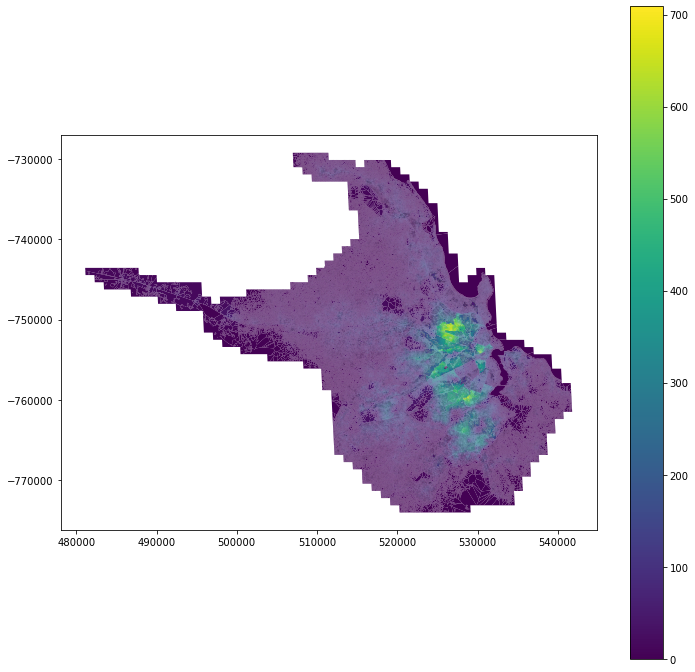

In [13]:
data.plot('population', figsize=(12, 12), legend=True, missing_kwds={"color": 'r'}, vmin=0)

In [11]:
mask = data.population < 0
data.population[mask] = 0

<ipython-input-11-2f3b25463834>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.population[mask] = 0


In [13]:
data[['tID', 'population']].to_parquet(folder + "population/population.pq")

#### land cover

In [14]:
download("https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2019/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif",
         folder + "land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif")


file_sizes: 100%|██████████████████████████| 95.6M/95.6M [00:03<00:00, 31.3MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif


'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'

In [3]:
lc = xarray.open_rasterio(folder + 'land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif')

In [4]:
lc_proj = lc.rio.reproject(data.crs)
lc_clip = lc_proj.rio.clip_box(*data.total_bounds)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [5]:
lc_clip.plot()

In [6]:
lc_clip

<xarray.DataArray (band: 1, y: 405, x: 549)>
array([[[116, 116, 116, ..., 200, 200, 200],
        [116, 116, 116, ..., 200, 200, 200],
        [126, 126, 114, ..., 200, 200, 200],
        ...,
        [116, 126, 126, ..., 126, 126, 126],
        [126, 126, 126, ..., 126, 116, 126],
        [126, 126, 126, ..., 126, 126, 126]]], dtype=uint8)
Coordinates:
  * x            (x) float64 4.811e+05 4.812e+05 ... 5.417e+05 5.418e+05
  * y            (y) float64 -7.293e+05 -7.294e+05 ... -7.739e+05 -7.741e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scales:                       (1.0,)
    offsets:                      (0.0,)
    archive_facility:             VITO NV
    AREA_OR_POINT:                Area
    copyright:                    Copernicus Service information 2020
    creator:                      Dr. Marcel Buchhorn (VITO)
    delivered_product_crs:        WGS84 (EPSG:4326)
    delivered_product_grid:       global 20x20 deg tiling grid
    delivered_product_tile_name:  E020N00
    doi:                          10.5281/zenodo.3939050
    file_creation:                Mon Jul 13 20:02:35 2020
    history:                      2020-07-10 Processing line LC100 v4.1
    Info:                         E020N00 for product Discrete-Classification...
    institution:                  VITO NV
    long_name:                    Land Cover
    NODATA_value:                 255
    orbit_type:                   LEO
    platform:                     Proba-V
    processing_level:             L3
    processing_mode:              Offline
    production_crs:               UTM
    production_grid:              MGRS (Sentinel-2 tiling grid)
    product_version:              v3.0.1
    references:                   https://land.copernicus.eu/global/products/lc
    region_name:                  global
    sensor:                       VEGETATION
    source:                       Derived from EO satellite imagery
    time_coverage_end:            2020-03-31T23:59:59Z
    time_coverage_start:          2017-04-01T00:00:00Z
    time_reference_year:          2019
    title:                        Dynamic Land Cover Map 100m 2019-nrt
    grid_mapping:                 spatial_ref
    _FillValue:                   255

In [9]:
arr = lc_clip.values
affine = lc_clip.rio.transform()

In [10]:
arr.shape

(1, 405, 549)

In [12]:
%%time 
stats_use = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['majority'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 16min 25s, sys: 34.8 s, total: 17min
Wall time: 17min


In [13]:
data['land_cover'] = [x['majority'] for x in stats_use]

<AxesSubplot:>

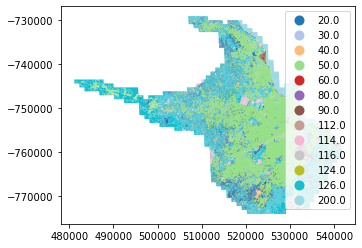

In [20]:
data.plot("land_cover", categorical=True, legend=True, cmap='tab20')

In [21]:
data[["land_cover", "tID"]].to_parquet(folder + "land_cover/land_cover.pq")

### night lights

From https://eogdata.mines.edu/download_dnb_composites.html.

Requires login. Downloaded manually.

In [11]:
nl = xarray.open_rasterio(folder + 'night_lights/SVDNB_npp_20200601-20200630_00N060W_vcmcfg_v10_c202008012300.avg_rade9h.tif')

In [14]:

bounds = gpd.GeoSeries(box(*data.total_bounds), crs=data.crs).to_crs(nl.crs)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [15]:
nl_clip = nl.rio.clip_box(*bounds.total_bounds)
nl_proj = nl_clip.rio.reproject(data.crs)

In [16]:
arr = nl_proj.values
affine = nl_proj.rio.transform()

In [17]:
%%time 
stats_nl = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 15min 51s, sys: 34.7 s, total: 16min 26s
Wall time: 16min 26s


In [18]:
data['lights'] = [x['mean'] for x in stats_nl]

<AxesSubplot:>

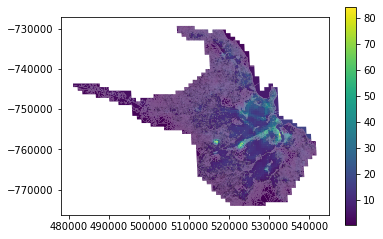

In [19]:
data.plot("lights", legend=True)

In [20]:
data[["lights", "tID"]].to_parquet(folder + "night_lights/night_lights.pq")

### NDVI

In [2]:
local_dir = "../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/"

In [3]:
tiles = geopandas.read_file("../../data_processing/imagery/GHS-composite-S2.geojson")

In [4]:
dar_es_salaam = geopandas.read_parquet(folder + "nodes.pq")

In [5]:
dar_es_salaam_extent = geopandas.GeoSeries(box(*dar_es_salaam.total_bounds), crs=dar_es_salaam.crs).to_crs(tiles.crs).iloc[0]

In [9]:
meta = tiles[tiles.intersects(dar_es_salaam_extent)]
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])
dar_es_salaam.crs

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<Projected CRS: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Wor ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
out = meta.iloc[[0]].apply(utils.process_scene, 
                   axis=1,
                   t_crs="EPSG:32637",
                   progressbar=True,
                  )

14/01/2021 14:57:19 | Working on Tile 37M - File: S2_percentile_UTM_636-0000069888-0000023296.tif

file_sizes: 100%|██████████████████████████| 2.28G/2.28G [01:33<00:00, 24.5MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296.tif
	14/01/2021 14:58:53 | rio warp ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296.tif ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296_osgb.tif --threads 16 --dst-crs EPSG:32637
	14/01/2021 15:04:09 | rm ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296.tif
	Split-opt.
		14/01/2021 15:06:00 | Optimising S2_percentile_UTM_636-0000069888-0000023296_wm_R.tif
		14/01/2021 15:08:31 | Optimising S2_percentile_UTM_636-0000069888-0000023296_wm_G.tif
		14/01/2021 15:10:59 | Optimising S2_percentile_UTM_636-0000069888-0000023296_wm_B

KeyboardInterrupt: 

In [11]:
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296_osgb.tif")

In [17]:
sub = r.sel(band=[1, 2, 3]).rio.clip_box(*dar_es_salaam.total_bounds)

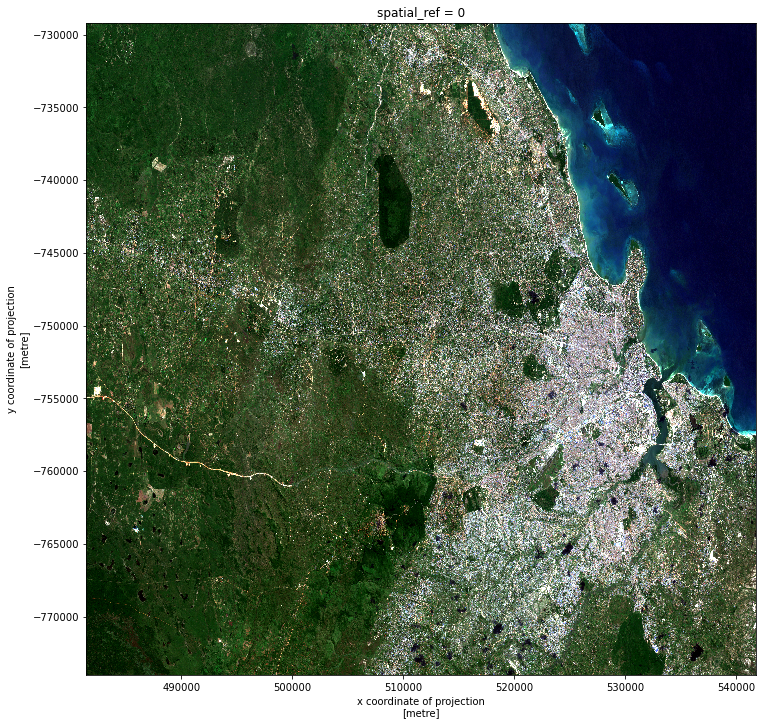

In [18]:
def minmax(a, 
           bottom=0, 
           top=255, 
           min_cut=2.5, 
           max_cut=98.5
          ):
    vals = a.to_series().values
    min_bin = percentile(vals, min_cut)
    max_bin = percentile(vals, max_cut)
    a = xarray.where(a > max_bin, max_bin, a)
    a = xarray.where(a < min_bin, min_bin, a)
    a_std = (a - a.min()) / (a.max() - a.min())
    a_scaled = a_std * (top - bottom) + bottom
    return a_scaled.astype(int)

sub.groupby("band")\
   .map(minmax)\
   .plot.imshow(figsize=(12, 12));

In [14]:
dar_es_salaam = geopandas.read_parquet(folder + "tessellation.pq")
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296_osgb.tif")

In [15]:
dar_es_salaam.crs.equals(r.rio.crs)

True

In [16]:
clipped = r.rio.clip_box(*dar_es_salaam.total_bounds)
masked = clipped.where(clipped != 0)

In [17]:
ndvi = (masked.sel(band=4) - masked.sel(band=1)) / (masked.sel(band=4) + masked.sel(band=1))

In [18]:
ndvi.min(), ndvi.max()

(<xarray.DataArray ()>
 array(-0.66080225)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(0.85430464)
 Coordinates:
     spatial_ref  int64 0)

In [19]:
affine = ndvi.rio.transform()

In [20]:
%%time
stats = rasterstats.zonal_stats(
    dar_es_salaam.geometry, 
    raster=ndvi.values,
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 28min 54s, sys: 1min 7s, total: 30min 1s
Wall time: 30min 1s


In [21]:
dar_es_salaam['ndvi'] = [x["mean"] for x in stats]

In [23]:
dar_es_salaam

uID                                           geometry    eID  \
0        784070.0  POLYGON ((530753.667 -751662.183, 530753.915 -...      0   
1        785052.0  POLYGON ((530753.915 -751662.504, 530753.667 -...      0   
2        785854.0  POLYGON ((530710.355 -751642.103, 530709.850 -...      0   
3        786074.0  POLYGON ((530709.663 -751625.639, 530708.164 -...      0   
4        786327.0  POLYGON ((530744.095 -751637.861, 530744.095 -...      0   
...           ...                                                ...    ...   
1168891       NaN  POLYGON ((531621.072 -756221.064, 531623.115 -...  19920   
1168892       NaN  POLYGON ((531623.115 -756235.533, 531621.072 -...  19921   
1168893       NaN  POLYGON ((531617.995 -756192.298, 531621.072 -...  19922   
1168894       NaN  POLYGON ((531621.072 -756221.064, 531617.995 -...  19923   
1168895   13275.0  POLYGON ((520256.963 -771339.718, 520250.096 -...  19925   

             ndvi  
0        0.137347  
1        0.230215  
2        0.277036  
3        0.389978  
4        0.372431  
...           ...  
1168891  0.413103  
1168892  0.470519  
1168893  0.498046  
1168894  0.492762  
1168895  0.452588  

[1168896 rows x 4 columns]

In [24]:
dar_es_salaam[["ndvi"]].to_parquet(folder + "ndvi.pq")

In [25]:
dar_es_salaam.plot('ndvi', legend=True, figsize=(12, 12))

<AxesSubplot:>

## Cluster analysis

In [2]:
form = pd.read_parquet(folder + "convolutions.pq")
tess = gpd.read_parquet(folder + "tess.pq", columns=["tessellation", "buildings", "tID"])

In [4]:
form.isna().any().any()

False

In [3]:
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(form)

In [6]:
cg_form = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_form.fit(data)

PCA computed in 5.0252156257629395 seconds.
K=1 fitted in 6.417876720428467 seconds.
K=2 fitted in 14.790470361709595 seconds.
K=3 fitted in 27.801873445510864 seconds.
K=4 fitted in 33.64905047416687 seconds.
K=5 fitted in 47.53295087814331 seconds.
K=6 fitted in 50.05953931808472 seconds.
K=7 fitted in 53.77879548072815 seconds.
K=8 fitted in 69.17621660232544 seconds.
K=9 fitted in 70.32597970962524 seconds.
K=10 fitted in 110.81906867027283 seconds.
K=11 fitted in 103.7469425201416 seconds.
K=12 fitted in 106.3141736984253 seconds.
K=13 fitted in 114.76011681556702 seconds.
K=14 fitted in 132.92218255996704 seconds.
K=15 fitted in 150.7171812057495 seconds.
K=16 fitted in 147.85379314422607 seconds.
K=17 fitted in 156.30348300933838 seconds.
K=18 fitted in 168.4539511203766 seconds.
K=19 fitted in 188.40414571762085 seconds.
K=20 fitted in 170.37180757522583 seconds.
K=21 fitted in 190.67729091644287 seconds.
K=22 fitted in 199.3429205417633 seconds.
K=23 fitted in 242.990885257720

In [8]:
ax = cg_form.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-10, 15)

(-10.0, 15.0)

In [9]:
with open(folder + 'clustergram_form.pickle','wb') as f:
    pickle.dump(cg_form, f)

In [10]:
%time km_form = KMeans(n_clusters=11, n_init=100).fit(data)

CPU times: user 2h 3min 54s, sys: 17min 19s, total: 2h 21min 13s
Wall time: 17min 17s


In [11]:
tess['clusters_form'] = km_form.labels_

In [12]:
ax = tess.plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [13]:
ax = tess.set_geometry('buildings').plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### Function

In [4]:
population = pd.read_parquet(folder + "population/population.pq")
land_cover = pd.read_parquet(folder + "land_cover/land_cover.pq")
night_lights = pd.read_parquet(folder + "night_lights/night_lights.pq")
ndvi = pd.read_parquet(folder + "ndvi.pq")

In [5]:
function_data = population.merge(land_cover, on='tID').merge(night_lights, on='tID')

In [6]:
function_data['ndvi'] = ndvi.ndvi.values

In [7]:
function_data = function_data.set_index('tID')
function_data

population  land_cover  lights      ndvi
tID                                              
0         96.060898        50.0   23.49  0.137347
1         89.316628        50.0   23.49  0.230215
2         87.038872        50.0   23.49  0.277036
3         87.038872        50.0   23.49  0.389978
4         86.569374        50.0   23.49  0.372431
...             ...         ...     ...       ...
1168891   81.500267        20.0   33.75  0.413103
1168892   79.141024        20.0   33.75  0.470519
1168893   82.881916        20.0   33.75  0.498046
1168894   80.255351        20.0   33.75  0.492762
1168895   12.635864       126.0    3.99  0.452588

[1168896 rows x 4 columns]

In [8]:
land = pd.get_dummies(function_data.land_cover)

In [9]:
scaler = preprocessing.StandardScaler()
f_data = scaler.fit_transform(function_data.drop(columns=["land_cover"]))

In [10]:
f_data = np.hstack([f_data, land.values])

In [29]:
f_data.shape

(1168896, 16)

In [30]:
np.isnan(f_data).any().any()

False

In [31]:
cg_function = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_function.fit(f_data)

PCA computed in 2.2545342445373535 seconds.
K=1 fitted in 1.2844197750091553 seconds.
K=2 fitted in 2.7105469703674316 seconds.
K=3 fitted in 5.104195594787598 seconds.
K=4 fitted in 6.409515619277954 seconds.
K=5 fitted in 8.71783185005188 seconds.
K=6 fitted in 13.041243314743042 seconds.
K=7 fitted in 15.236485004425049 seconds.
K=8 fitted in 16.622711896896362 seconds.
K=9 fitted in 25.22173500061035 seconds.
K=10 fitted in 31.26101064682007 seconds.
K=11 fitted in 35.01960730552673 seconds.
K=12 fitted in 35.51231575012207 seconds.
K=13 fitted in 43.99436616897583 seconds.
K=14 fitted in 40.28325915336609 seconds.
K=15 fitted in 45.70191526412964 seconds.
K=16 fitted in 47.9129536151886 seconds.
K=17 fitted in 57.398313999176025 seconds.
K=18 fitted in 65.83624958992004 seconds.
K=19 fitted in 60.56449866294861 seconds.
K=20 fitted in 78.49006748199463 seconds.
K=21 fitted in 78.68227291107178 seconds.
K=22 fitted in 71.40852665901184 seconds.
K=23 fitted in 107.72213530540466 sec

In [32]:
ax = cg_function.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})

In [33]:
with open(folder + 'clustergram_function.pickle','wb') as f:
    pickle.dump(cg_function, f)

In [34]:
km_function = KMeans(n_clusters=10, n_init=100).fit(f_data)

In [35]:
tess['clusters_function'] = km_function.labels_

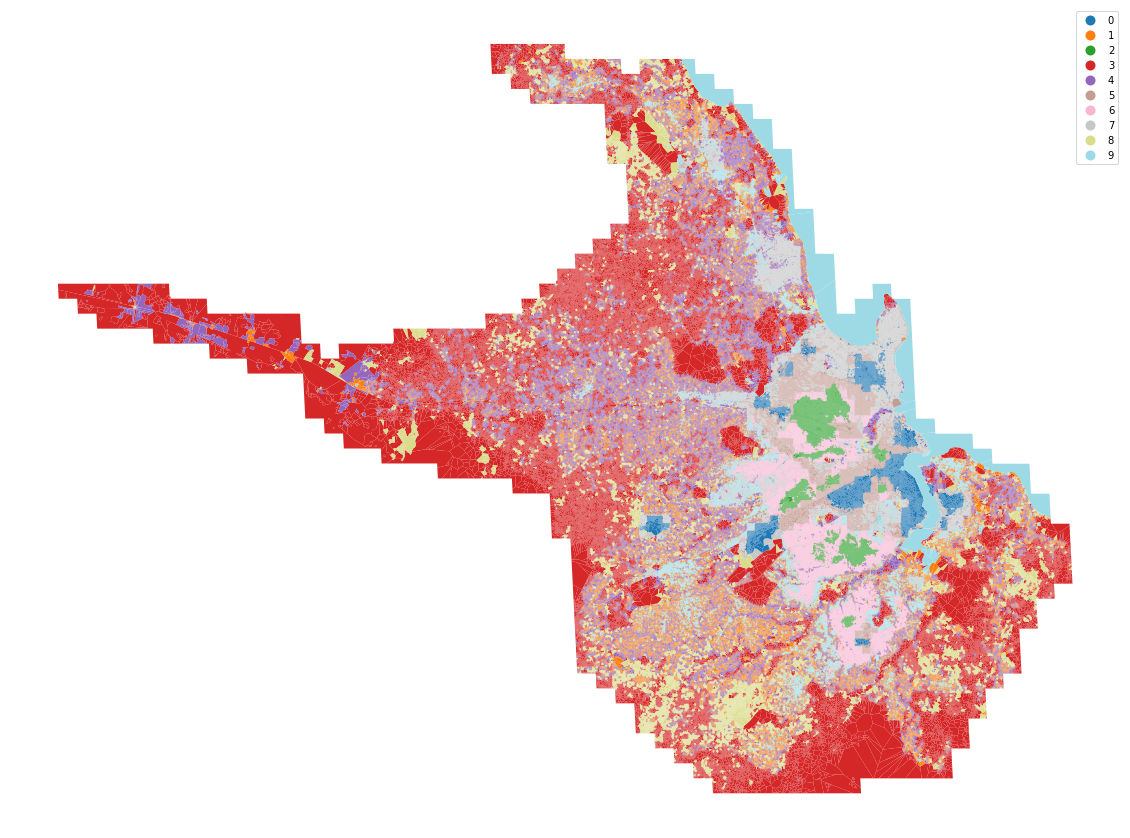

In [36]:
ax = tess.plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

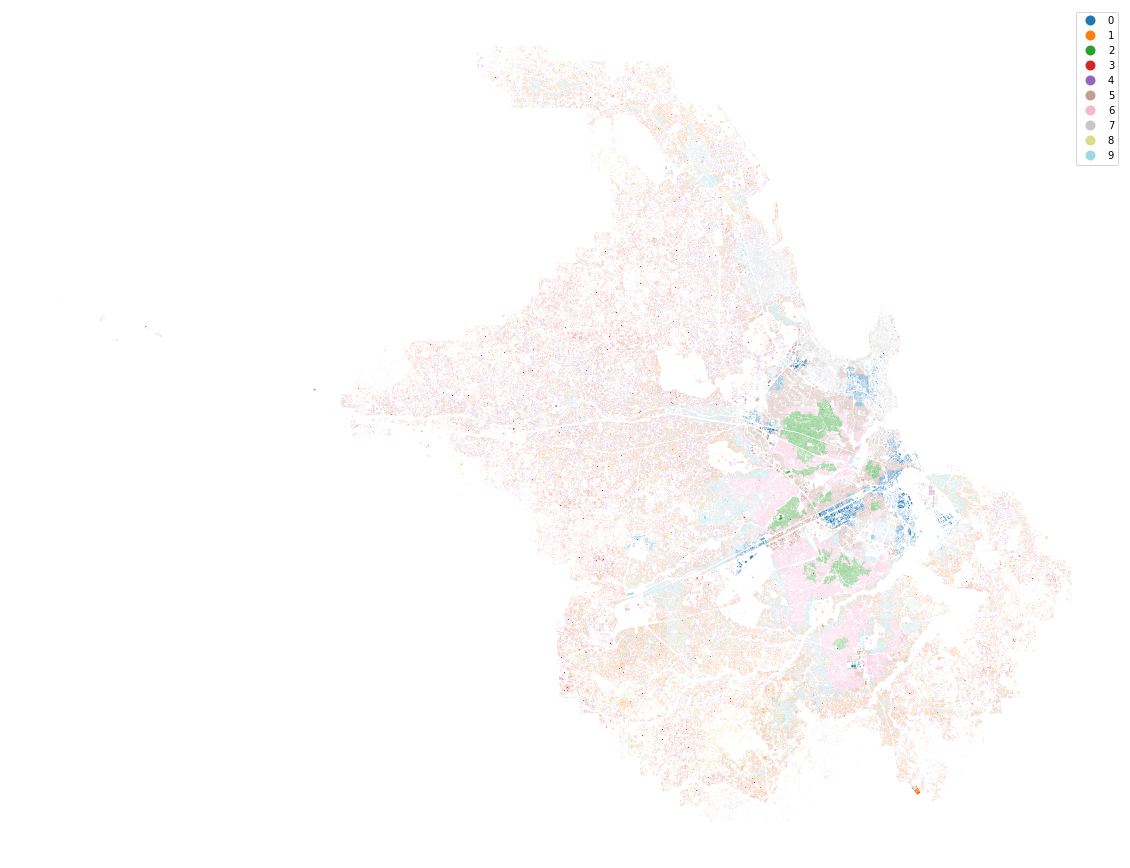

In [37]:
ax = tess.set_geometry('buildings').plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [11]:
ss_data = np.hstack([data, f_data])

In [39]:
cg_ss = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_ss.fit(ss_data)

PCA computed in 5.388461589813232 seconds.
K=1 fitted in 6.160102367401123 seconds.
K=2 fitted in 15.988403797149658 seconds.
K=3 fitted in 30.696676015853882 seconds.
K=4 fitted in 51.67863893508911 seconds.
K=5 fitted in 42.06236743927002 seconds.
K=6 fitted in 48.497129917144775 seconds.
K=7 fitted in 62.672199726104736 seconds.
K=8 fitted in 77.37391686439514 seconds.
K=9 fitted in 82.32746052742004 seconds.
K=10 fitted in 94.71895551681519 seconds.
K=11 fitted in 143.8769154548645 seconds.
K=12 fitted in 103.95307493209839 seconds.
K=13 fitted in 126.36029815673828 seconds.
K=14 fitted in 119.76749229431152 seconds.
K=15 fitted in 128.79357051849365 seconds.
K=16 fitted in 152.92554020881653 seconds.
K=17 fitted in 151.35402035713196 seconds.
K=18 fitted in 189.52728128433228 seconds.
K=19 fitted in 171.2427942752838 seconds.
K=20 fitted in 212.5317280292511 seconds.
K=21 fitted in 193.01844334602356 seconds.
K=22 fitted in 222.87897634506226 seconds.
K=23 fitted in 229.8445725440

In [42]:
ax = cg_ss.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-10, 15)

(-10.0, 15.0)

In [41]:
with open(folder + 'clustergram_ss.pickle','wb') as f:
    pickle.dump(cg_ss, f)

In [ ]:
%time km = KMeans(n_clusters=17, n_init=1000, random_state=12345).fit(ss_data)

In [ ]:
tess['clusters'] = km.labels_

In [24]:
ax = tess.plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [25]:
ax = tess.set_geometry('buildings').plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [47]:
tess[['tID', 'clusters', 'clusters_form', 'clusters_function']].to_parquet(folder + "cluster_labels.pq")

In [ ]:
tess[['tID', 'clusters']].to_parquet(folder + "FINAL_cluster_labels.pq")

In [23]:
tess

tessellation  \
0        POLYGON ((530753.667 -751662.183, 530753.915 -...   
1        POLYGON ((530753.915 -751662.504, 530753.667 -...   
2        POLYGON ((530710.355 -751642.103, 530709.850 -...   
3        POLYGON ((530709.663 -751625.639, 530708.164 -...   
4        POLYGON ((530744.095 -751637.861, 530744.095 -...   
...                                                    ...   
1168891  POLYGON ((531621.072 -756221.064, 531623.115 -...   
1168892  POLYGON ((531623.115 -756235.533, 531621.072 -...   
1168893  POLYGON ((531617.995 -756192.298, 531621.072 -...   
1168894  POLYGON ((531621.072 -756221.064, 531617.995 -...   
1168895  POLYGON ((520256.963 -771339.718, 520250.096 -...   

                                                 buildings      tID  clusters  
0        POLYGON ((530671.226 -751656.231, 530671.497 -...        0        16  
1        POLYGON ((530746.821 -751631.899, 530756.257 -...        1        16  
2        POLYGON ((530680.755 -751609.597, 530694.811 -...        2        16  
3        POLYGON ((530696.687 -751613.442, 530705.825 -...        3        16  
4        POLYGON ((530727.804 -751594.126, 530743.086 -...        4        16  
...                                                    ...      ...       ...  
1168891                                               None  1168891        16  
1168892                                               None  1168892        16  
1168893                                               None  1168893        16  
1168894                                               None  1168894        16  
1168895  POLYGON ((520126.173 -771307.830, 520126.315 -...  1168895         3  

[1168896 rows x 4 columns]